# Génération de mélodies avec un RNN-LSTM - Partie 2 : training
ressource: tuto youtube *Melody generation with RNN-LSTM* de *Valerio Velardo*

In [22]:
import os
import music21 as m21
import json
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt

### Paramètres

In [23]:
SEQUENCE_LENGTH = 64
FILE_DATASET_PATH = "data/han/file_dataset"
MAPPINGS_PATH = "data/han/mapping.json"

OUTPUT_UNITS = 43 # Nb de lignes dans fichier mapping
NUM_UNITS = [256]
LOSS = "sparse_categorical_crossentropy"
LEARNING_RATE = 0.001

EPOCHS = 10
BATCH_SIZE = 64

MODEL_PATH = "model_RNN_LSTM.keras"

charger fichier de données et fichier de mapping

In [24]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

songs = load(FILE_DATASET_PATH)

def load_json(file_path):
    with open(file_path, "r") as fp:
        mappings = json.load(fp)
    return mappings

mappings = load_json(MAPPINGS_PATH)

In [25]:
print(songs)
# print(songs.split())
print(mappings)
# print(mappings['66'])
# for symbol in songs.split():
#     print(mappings[symbol])

74 _ _ _ 69 _ 72 _ 74 _ _ _ 74 _ _ _ 69 _ _ 72 74 _ 79 _ 72 _ 69 _ 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 67 _ 66 _ 67 _ _ _ 67 _ _ 69 72 _ 74 _ 74 _ _ _ 72 _ 74 _ 67 _ _ _ 62 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ 69 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 72 _ 69 _ 72 _ _ 69 67 _ 72 _ 69 _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ _ _ _ _ _ _ 62 _ 62 62 62 _ 67 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ 60 _ 58 _ _ _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ _ _ _ _ 62 _ _ _ 64 _ 62 _ 60 _ _ _ _ _ 64 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / /

générer séquences d'entrainements

In [26]:
def convert_songs_to_int(songs, mappings):
    # Conversion des datas  74 _ _ _ 69 en integers suivant le mapping
    
    int_songs = []

    songs = songs.split() # 74 _ _ _ 69 --> ['74', '_', '_', '_', '69']

    # map songs to int
    for symbol in songs:
        int_songs.append(mappings[symbol])

    return int_songs

In [27]:
def generate_training_sequences(sequence_length, songs, mappings):
    """Create input and output data samples for training. Each sample is a sequence.

    :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars
    :param songs (string) : songs datas
    :param mappings (dict): mapping between 

    :return inputs (ndarray): Training inputs
    :return targets (ndarray): Training targets
    """

    # map songs to int
    int_songs = convert_songs_to_int(songs, mappings)

    inputs = [] # fenetre qu'on décalle
    targets = [] # note qu'on cherche à prédire à partir de la séquence d'input

    # generate the training sequences
    num_sequences = len(int_songs) - sequence_length
    for i in range(num_sequences):
        inputs.append(int_songs[i:i+sequence_length])
        targets.append(int_songs[i+sequence_length])

    # one-hot encode the sequences
    vocabulary_size = len(set(int_songs))
    # inputs size: (# of sequences, sequence length, vocabulary size)
    inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
    targets = np.array(targets)

    return inputs, targets

In [28]:
inputs, targets = generate_training_sequences(64, songs, mappings)

### Entrainement

In [29]:
def build_model(output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model)
    """

    # create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()

    return model

In [30]:
# build the model
model = build_model(OUTPUT_UNITS, NUM_UNITS, LOSS, LEARNING_RATE)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, None, 43)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 256)            │       307,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,251 (1.21 MB)

 Trainable params: 318,251 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# train the model

history = model.fit(inputs, targets, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 180s 55ms/step - accuracy: 0.6762 - loss: 1.1636
Epoch 2/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 174s 53ms/step - accuracy: 0.7175 - loss: 0.8817
Epoch 3/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 176s 54ms/step - accuracy: 0.7230 - loss: 0.8535
Epoch 4/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 175s 53ms/step - accuracy: 0.7327 - loss: 0.8245
Epoch 5/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 176s 54ms/step - accuracy: 0.7393 - loss: 0.8017
Epoch 6/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 177s 54ms/step - accuracy: 0.7424 - loss: 0.7880
Epoch 7/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 176s 54ms/step - accuracy: 0.7457 - loss: 0.7708
Epoch 8/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 177s 54ms/step - accuracy: 0.7522 - loss: 0.7503
Epoch 9/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 179s 54ms/step - accuracy: 0.7551 - loss: 0.7380
Epoch 10/10
3278/3278 ━━━━━━━━━━━━━━━━━━━━ 178s 54ms/step - accuracy: 0.7581 - loss: 0.7265


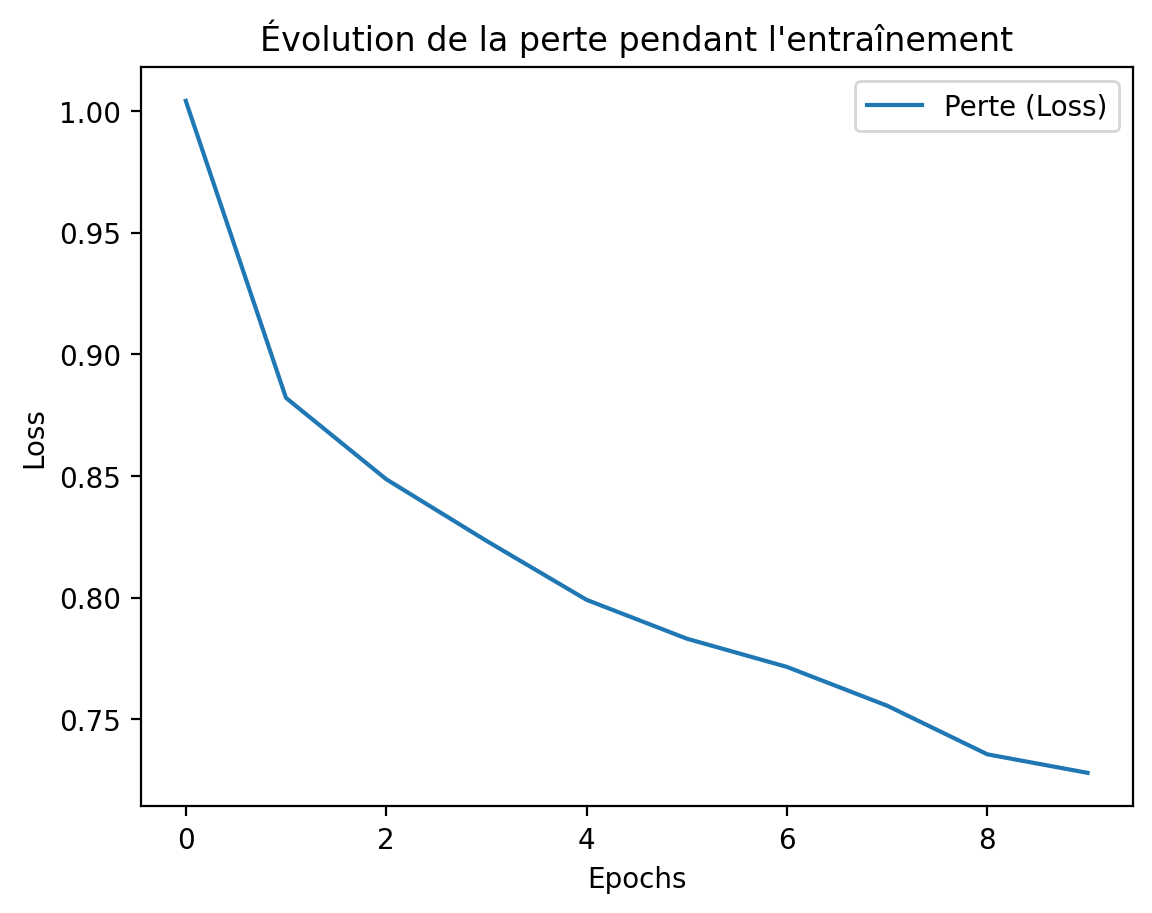

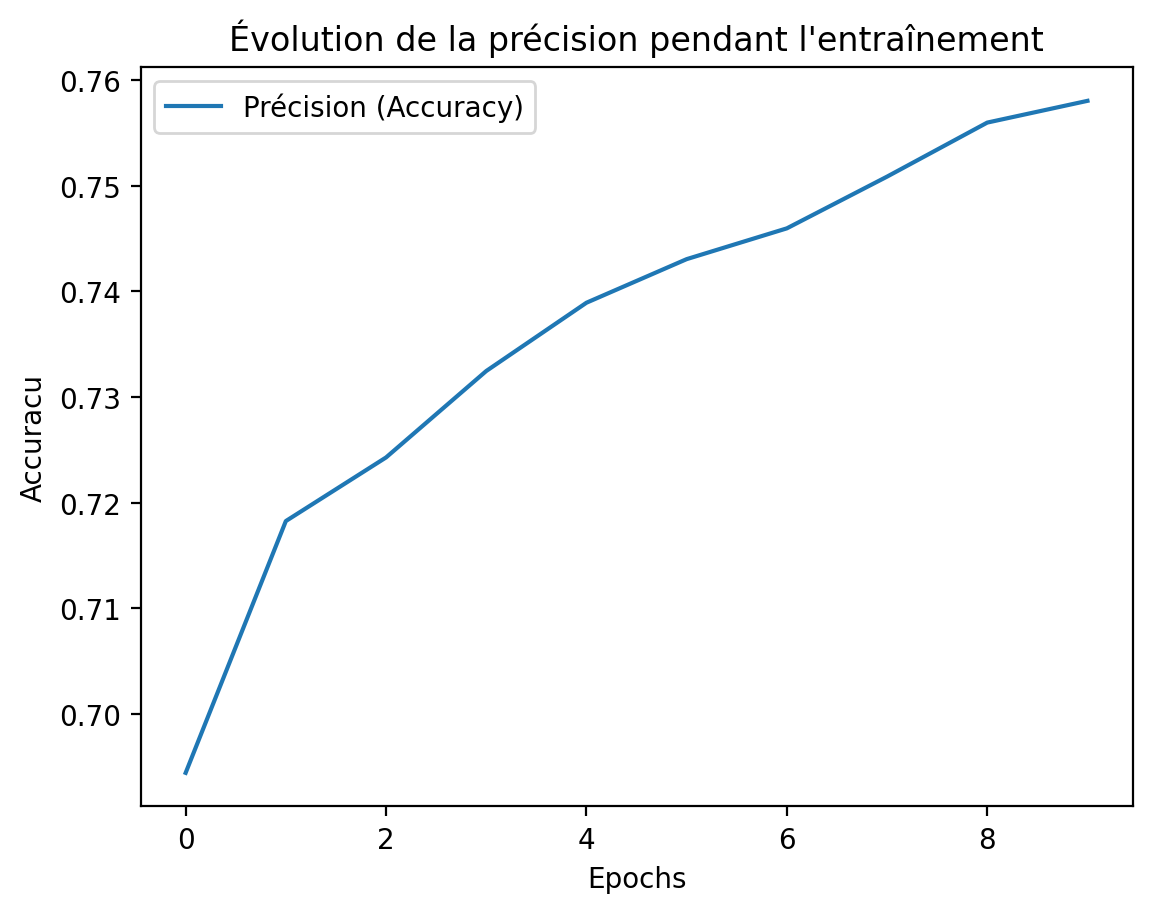

In [32]:
# Affichage de la loss
plt.plot(history.history['loss'], label='Perte (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Évolution de la perte pendant l'entraînement")
plt.legend()
plt.show()

# Affichache accuracy
plt.plot(history.history['accuracy'], label='Précision (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracu')
plt.title("Évolution de la précision pendant l'entraînement")
plt.legend()
plt.show()

In [33]:
# save the model
model.save(MODEL_PATH)